<a href="https://colab.research.google.com/github/aayush1036/DogBreedIdentification/blob/master/Dog_Breed_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
Presented by:
Aryaman Gautam (J001)
Aayushmaan Jain (J022)
Pratyush Patro (J047)
Milindi Shah (J057)
```

# Imports 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.express as px
import numpy as np 
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from utils import * 
from google.colab import drive

# Checking for GPU availability

In [2]:
print(f'Supports GPU -> {tf.test.is_built_with_gpu_support()}')
print(f'Supports CUDA -> {tf.test.is_built_with_cuda()}')
print(f"Number of GPU -> {len(tf.config.list_physical_devices('GPU'))}")

Supports GPU -> True
Supports CUDA -> True
Number of GPU -> 1


# Fetching Data

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/train.zip &> /dev/null

# Creating the datasets for model building 

In [3]:
labels = pd.read_csv('/content/drive/MyDrive/labels.csv')
labels['id'] = labels['id'].apply(lambda x: f'{x}.jpg')
labels.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07.jpg       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97.jpg             dingo
2  001cdf01b096e06d78e9e5112d419397.jpg          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d.jpg          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62.jpg  golden_retriever

In [4]:
print(f"There are {labels['breed'].nunique()} breeds in the dataset")

There are 120 breeds in the dataset


In [5]:
top_20 = labels['breed'].value_counts()[:20]
fig = px.bar(data_frame=top_20, x=top_20.index, y=top_20.values, title='Top 20 most occuring breeds',labels={
    'index':'Breed',
    'y':'Number of dogs'})
fig.show()

In [6]:
test_size = int(labels.shape[0]*0.1)
train_data, test_data = train_test_split(labels, test_size=test_size, stratify=labels['breed'])
train_data, val_data = train_test_split(train_data, test_size=test_size, stratify=train_data['breed'])

assert val_data.shape == test_data.shape

In [7]:
augmentations = {
    'rescale':1/255.0,
    'shear_range':0.2,
    'zoom_range':0.2,
    'horizontal_flip':True
}
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(**augmentations)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

In [8]:
specifications = {
    'x_col':'id',
    'y_col':'breed',
    'directory':'train/train',
    'class_mode':'categorical',
    'target_size':(256,256),
    'batch_size':64
}
    
train_set = train_generator.flow_from_dataframe(dataframe=train_data,**specifications)
validation_set = train_generator.flow_from_dataframe(dataframe=val_data,**specifications)
test_set = test_generator.flow_from_dataframe(dataframe=test_data, **specifications)

Found 8178 validated image filenames belonging to 120 classes.
Found 1022 validated image filenames belonging to 120 classes.
Found 1022 validated image filenames belonging to 120 classes.


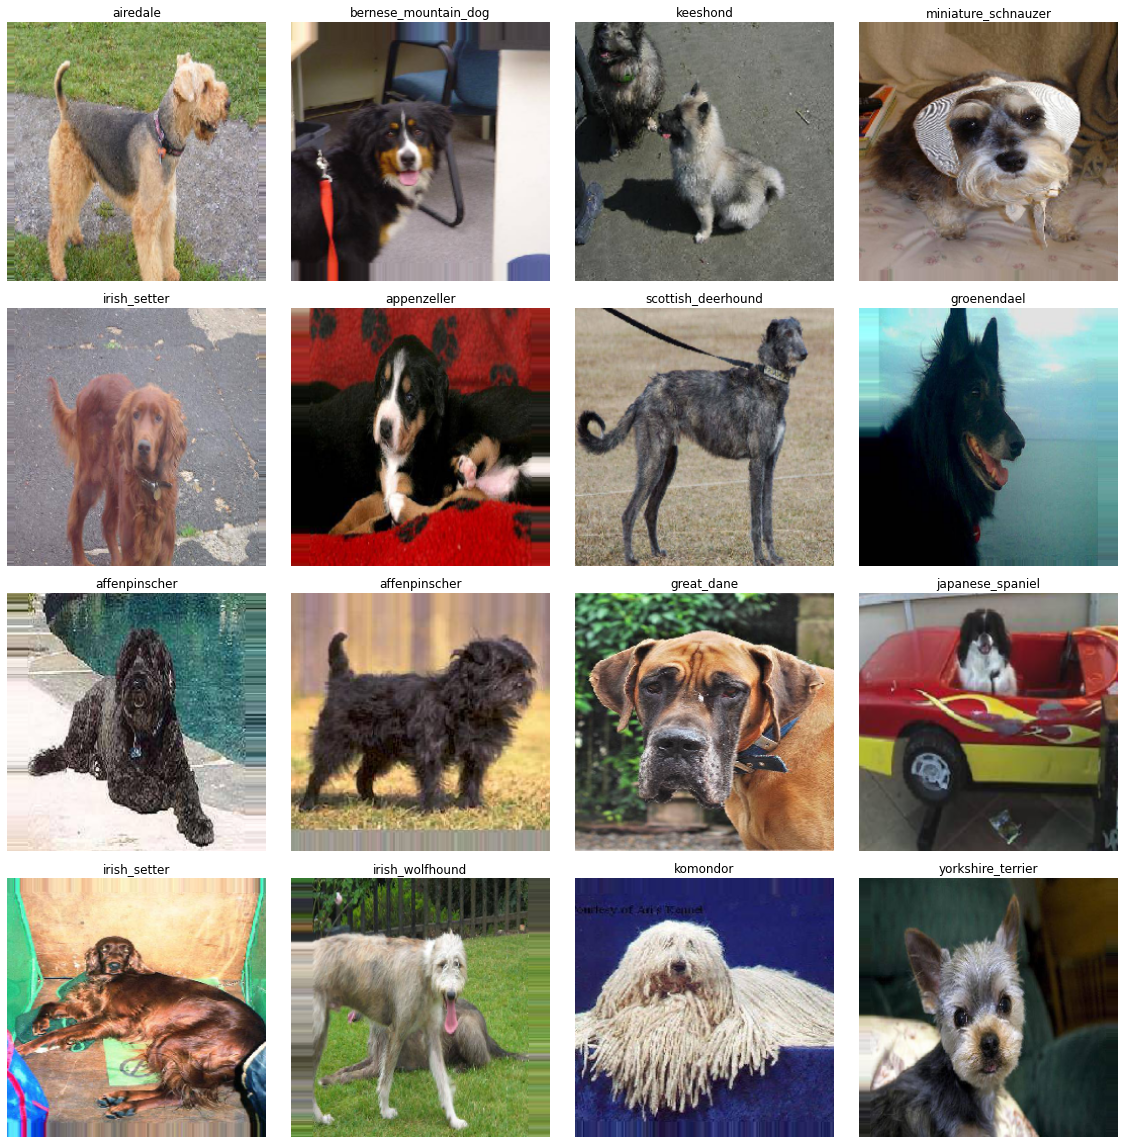

In [9]:
see_examples(train_set)

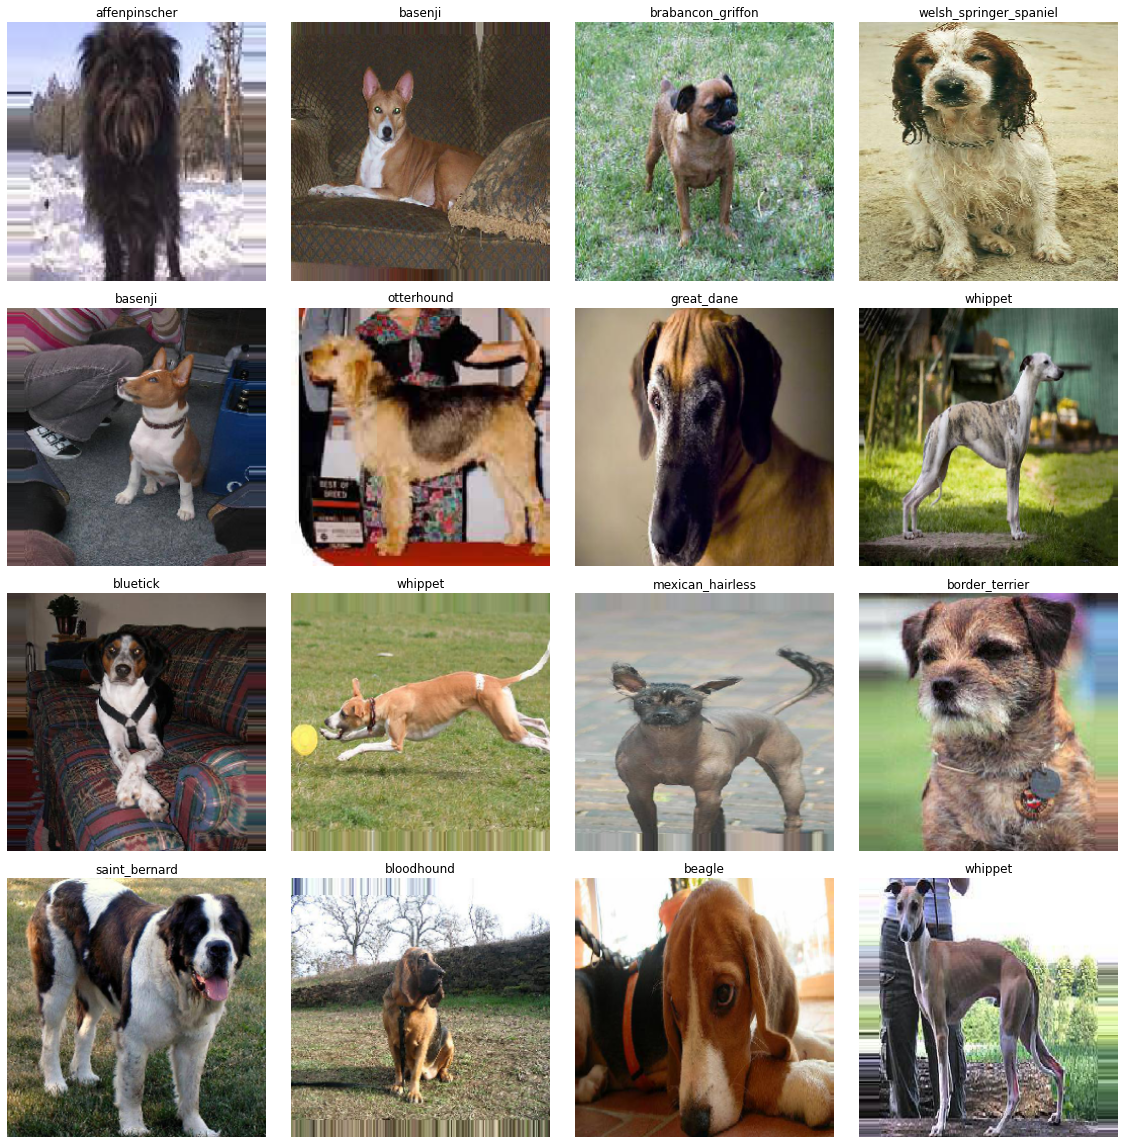

In [10]:
see_examples(validation_set)

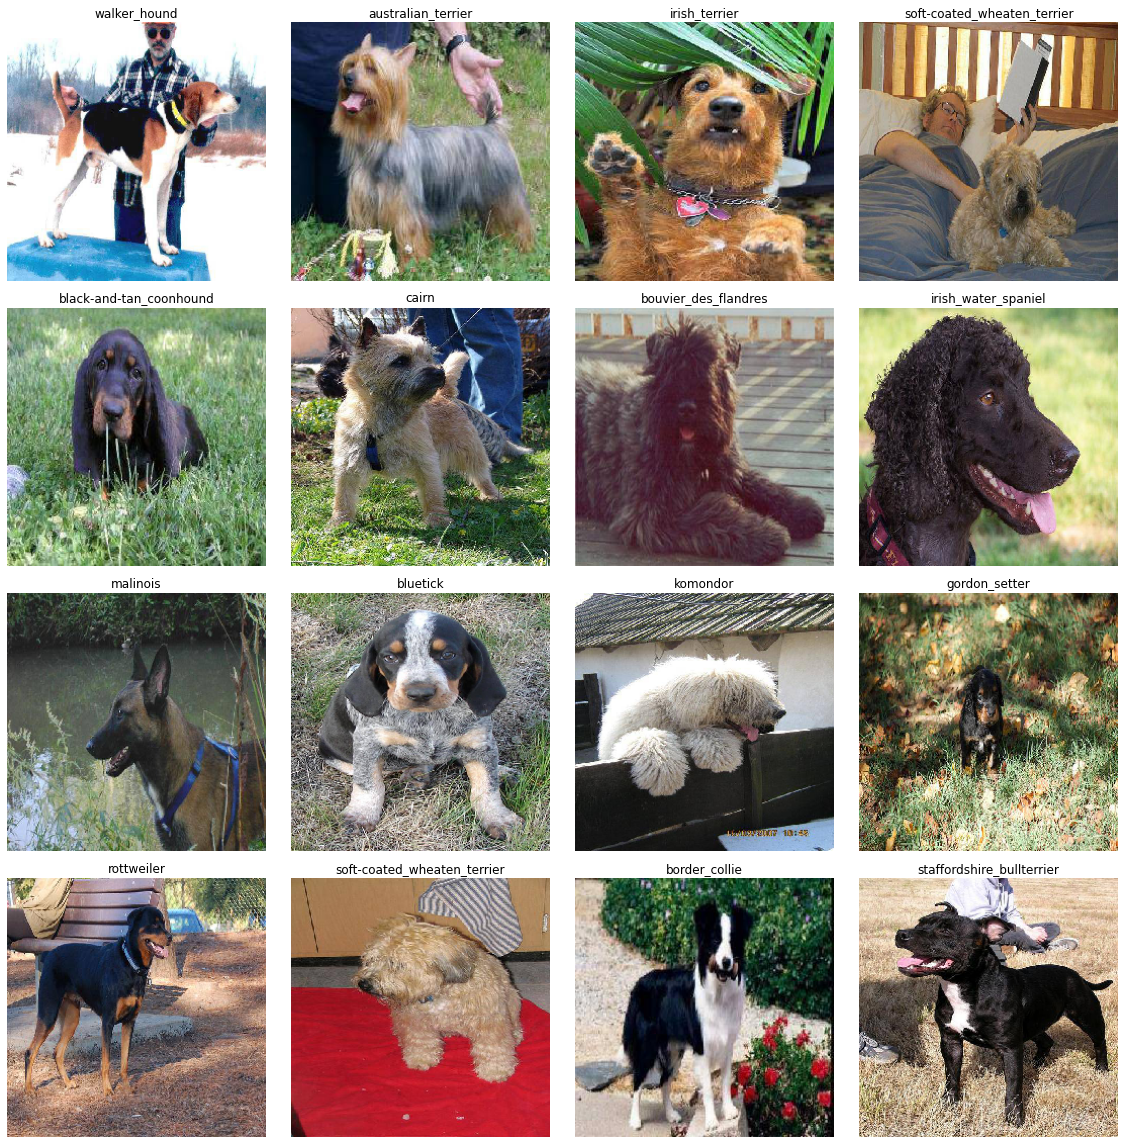

In [11]:
see_examples(test_set)

In [12]:
train_performance = []
val_performance = []
test_performance = []
names = []

In [13]:
conv_specs = {
    'kernel_size':(3,3),
    'activation':'relu'
}

In [14]:
inputs = tf.keras.layers.Input(shape=(256,256,3))
conv1 = tf.keras.layers.Conv2D(filters=32, **conv_specs,name='Convolution1')(inputs)
pooled1 = tf.keras.layers.MaxPooling2D(name='Pooling1')(conv1)
conv2 = tf.keras.layers.Conv2D(filters=64, **conv_specs, name='Convolution2')(pooled1)
pooled2 = tf.keras.layers.MaxPooling2D(name='Pooling2')(conv2)
conv3 = tf.keras.layers.Conv2D(filters=128, **conv_specs, name='Convolution3')(pooled2)
pooled3 = tf.keras.layers.MaxPooling2D(name='Pooling3')(conv3)
flatten = tf.keras.layers.Flatten(name='Flatten')(pooled3)
dropout = tf.keras.layers.Dropout(rate=0.3, name='Dropout')(flatten)
dense1 = tf.keras.layers.Dense(units=256, activation='relu',name='Dense1')(dropout)
outputs = tf.keras.layers.Dense(units=120, activation='softmax',name='Dense2')(dense1)

model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs], name='CustomModel')

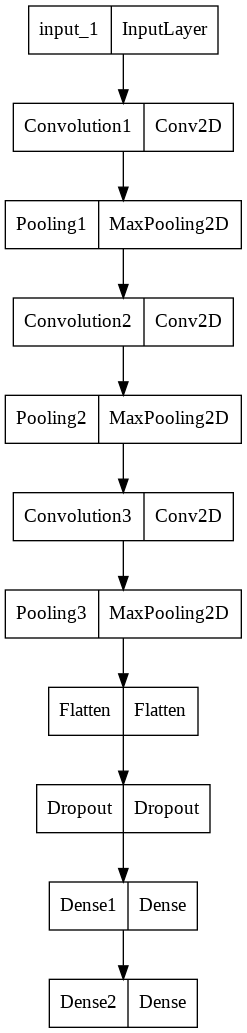

In [15]:
tf.keras.utils.plot_model(model)

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
save_best = tf.keras.callbacks.ModelCheckpoint(filepath='best_custom.h5',save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(min_delta=1e-4, patience=3)

In [18]:
fit_specs = {
    'epochs':10,
    'steps_per_epoch':train_set.n//train_set.batch_size,
    'validation_data':validation_set,
    'validation_steps':validation_set.n//validation_set.batch_size
}

In [19]:
history = model.fit(
    train_set, 
    **fit_specs,
    callbacks=[save_best, reduce_lr, early_stopping]
    )

Epoch 1/10
127/127 [==============================] - 242s 2s/step - loss: 4.7834 - accuracy: 0.0126 - val_loss: 4.7536 - val_accuracy: 0.0260 - lr: 1.0000e-04
Epoch 2/10
127/127 [==============================] - 197s 2s/step - loss: 4.7052 - accuracy: 0.0253 - val_loss: 4.6565 - val_accuracy: 0.0323 - lr: 1.0000e-04
Epoch 3/10
127/127 [==============================] - 169s 1s/step - loss: 4.5663 - accuracy: 0.0407 - val_loss: 4.5577 - val_accuracy: 0.0448 - lr: 1.0000e-04
Epoch 4/10
127/127 [==============================] - 166s 1s/step - loss: 4.4215 - accuracy: 0.0546 - val_loss: 4.4718 - val_accuracy: 0.0458 - lr: 1.0000e-04
Epoch 5/10
127/127 [==============================] - 167s 1s/step - loss: 4.2795 - accuracy: 0.0691 - val_loss: 4.3935 - val_accuracy: 0.0479 - lr: 1.0000e-04
Epoch 6/10
127/127 [==============================] - 172s 1s/step - loss: 4.1735 - accuracy: 0.0844 - val_loss: 4.3643 - val_accuracy: 0.0573 - lr: 1.0000e-04
Epoch 7/10
127/127 [====================

In [20]:
def evaluate(model,modelname):
    _, train_accuracy = model.evaluate(train_set)
    _, val_accuracy = model.evaluate(validation_set)
    _, test_accuracy = model.evaluate(test_set)
    train_performance.append(train_accuracy)
    val_performance.append(val_accuracy)
    test_performance.append(test_accuracy)
    names.append(modelname)

In [21]:
evaluate(model, modelname='Baseline')

16/16 [==============================] - 5s 297ms/step - loss: 4.3099 - accuracy: 0.0753


In [22]:
models = {
    'InceptionV3':tf.keras.applications.InceptionV3,
    'InceptionResnetV2':tf.keras.applications.InceptionResNetV2,
    'Xception':tf.keras.applications.Xception,
    'MobileNet':tf.keras.applications.MobileNet,
    'DenseNet201':tf.keras.applications.DenseNet201
}

In [23]:
pretrained_specifications = {
    'weights':'imagenet',
    'include_top':False
}

In [24]:
def make_pretrained_model(model_name:str):
    """Instatntiates the pre trained model architecture

    Args:
        model_name (str): The name of the architecture you would like to instantiate

    Returns:
        tf.keras.models.Model: The pre trained model architecture
    """    
    conv_base = models[model_name](**pretrained_specifications)
    conv_base.trainable=False
    inputs = tf.keras.layers.Input(shape=(256,256,3),name='Inputs')
    pretrained_output = conv_base(inputs)
    flatten = tf.keras.layers.Flatten(name='Flatten')(pretrained_output)
    dense1 = tf.keras.layers.Dense(units=128, activation='relu',name='Dense1')(flatten)
    outputs = tf.keras.layers.Dense(units=120,activation='softmax',name='Outputs')(dense1)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'])

    return model

In [25]:
def generate_callbacks(model_name:str):
    """
    Generates a model checkpoint callback for the models
    """
    callback = tf.keras.callbacks.ModelCheckpoint(f'best_{model_name}.h5', save_best_only=True)
    return callback

In [26]:
fitted_models = {}
history_dict = {}
for name, model in models.items():
    pretrained_model = make_pretrained_model(name)
    callback = generate_callbacks(name)
    print(f"{'='*50} Training {name} {'='*50}")
    history_dict[name] = pretrained_model.fit(train_set, 
                                              **fit_specs,
                                              callbacks=[callback])
    fitted_models[name] = pretrained_model
    evaluate(pretrained_model, modelname = name)


87924736/87910968 [==============================] - 1s 0us/step
================================================== Training InceptionV3 ==================================================
Epoch 1/10
127/127 [==============================] - 189s 1s/step - loss: 4.2173 - accuracy: 0.2008 - val_loss: 2.6637 - val_accuracy: 0.4010
Epoch 2/10
127/127 [==============================] - 174s 1s/step - loss: 2.0274 - accuracy: 0.5378 - val_loss: 1.7103 - val_accuracy: 0.6344
Epoch 3/10
127/127 [==============================] - 174s 1s/step - loss: 1.3966 - accuracy: 0.6647 - val_loss: 1.5339 - val_accuracy: 0.6417
Epoch 4/10
127/127 [==============================] - 174s 1s/step - loss: 1.1694 - accuracy: 0.7123 - val_loss: 1.5741 - val_accuracy: 0.6698
Epoch 5/10
127/127 [==============================] - 174s 1s/step - loss: 0.9696 - accuracy: 0.7529 - val_loss: 1.4176 - val_accuracy: 0.6917
Epoch 6/10
127/127 [==============================] - 177s 1s/step - loss: 0.8431 - accuracy: 0.7

In [27]:
performance_df = pd.DataFrame({
    'Train':train_performance,
    'Validation':val_performance,
    'Test':test_performance
},index=names)

In [42]:
performance_df.sort_values(by='Test', ascending=True)

Train  Validation      Test
Baseline           0.175104    0.057730  0.075342
MobileNet          0.101981    0.091977  0.102740
DenseNet201        0.300929    0.250489  0.247554
InceptionV3        0.842627    0.713307  0.713307
Xception           0.889826    0.727984  0.751468
InceptionResnetV2  0.877843    0.797456  0.806262

Since the best results were obtained by using the InceptionResnetV2 model, we will use inception model for further predictions

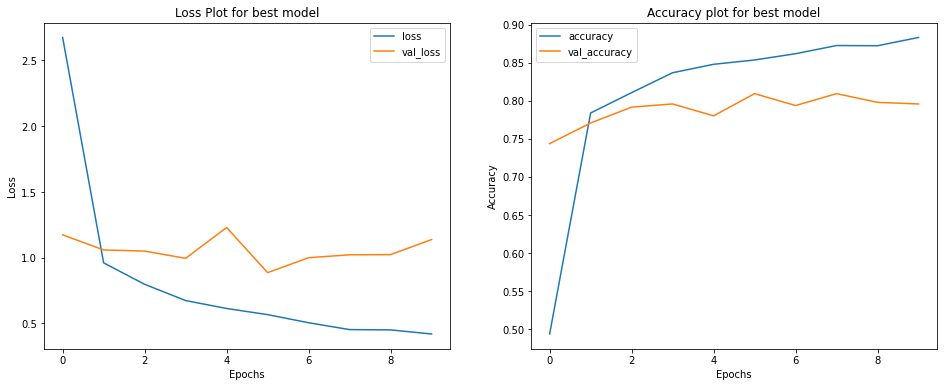

In [37]:
best_model_history = pd.DataFrame(history_dict['InceptionResnetV2'].history)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(16,6))
best_model_history[['loss', 'val_loss']].plot(ax=ax[0], title='Loss Plot for best model',xlabel='Epochs', ylabel='Loss')
best_model_history[['accuracy','val_accuracy']].plot(ax=ax[1], title='Accuracy plot for best model',xlabel='Epochs', ylabel='Accuracy')
plt.show()

In [38]:
best_model = tf.keras.models.load_model('/content/best_InceptionResnetV2.h5')

In [39]:
_, train_accuracy = best_model.evaluate(train_set)
_, val_accuracy = best_model.evaluate(validation_set)
_, test_accuracy =  best_model.evaluate(test_set)

16/16 [==============================] - 19s 1s/step - loss: 0.8832 - accuracy: 0.8072


In [40]:
print(f'Accuracy on train set -> {train_accuracy:.3%}')
print(f'Accuracy on val set -> {val_accuracy:.3%}')
print(f'The accuracy on test set -> {test_accuracy:.3%}')

Accuracy on train set -> 86.928%
Accuracy on val set -> 79.648%
The accuracy on test set -> 80.724%
